<a href="https://colab.research.google.com/github/SLTH-Project/ThSL-Model/blob/main/Train/Find_Pre_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/All Dataset/Github/Dataset_Original_100'

Mounted at /content/drive
/content/drive/MyDrive/All Dataset/Github/Dataset_Original_100


In [ ]:
%cd '/content'

/content


In [ ]:
from zipfile import ZipFile
file_name = '/content/Dataset_Original_SLTH_100_Resize2.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


#Import

In [ ]:
from numpy import expand_dims
import numpy as np

import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


import tensorflow
import tensorflow as tf

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

from PIL import Image 
from PIL import ImageFilter 

from scipy import ndimage
from skimage.transform import resize

import os
from os import listdir

import cv2
import time
import random

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers import BatchNormalization

#Split folder

In [ ]:
!pip install split_folders

In [ ]:
pip install split-folders tqdm

In [ ]:
import splitfolders 

## Train : Validation : Test 

In [ ]:
DATA_PATH = '/content/Dataset_Original_SLTH_100_Resize2'

Train set : 70%, Test set : 20%, Validation set : 10%

In [ ]:
SAVE_DATA_PATH = '/content/Dataset_Split_test2/'
os.makedirs(SAVE_DATA_PATH)

In [ ]:
splitfolders.ratio(DATA_PATH, output=SAVE_DATA_PATH, seed=1337, ratio=(0.7, 0.1, 0.2)) # (train:val:test)

Copying files: 12000 files [00:01, 8812.52 files/s]


#Load dataset

In [ ]:
SIZE =224
CLASS_MODE = 'sparse'  #sparse
BATCH_SIZE = 32
NUM_CLASS=100
COLOR_MODE ='rgb'
CHANNEL = 3

In [ ]:
root_dir = '/content/'
dataset_dir = os.path.join(root_dir, 'Dataset_Split_test2')
train_dir = os.path.join(dataset_dir,'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

Trian

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input ,dtype='float32') #included in our dependencies
train_generator = train_datagen.flow_from_directory(train_dir, # this is where you specify the path to the main data folder
                                                 target_size=(SIZE, SIZE),
                                                 color_mode=COLOR_MODE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 seed=123,
                                                 shuffle=True
                                                 )

Found 8400 images belonging to 100 classes.


Test

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,dtype='float32') #included in our dependencies
test_generator = train_datagen.flow_from_directory(test_dir, # this is where you specify the path to the main data folder
                                                  target_size=(SIZE, SIZE),
                                                 color_mode=COLOR_MODE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 seed=123,
                                                 shuffle=False
                                                 )

Found 2400 images belonging to 100 classes.


In [ ]:
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,dtype='float32') #included in our dependencies
val_generator = val_datagen.flow_from_directory(val_dir, # this is where you specify the path to the main data folder
                                                  target_size=(SIZE, SIZE),
                                                 color_mode=COLOR_MODE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 seed=123,
                                                 shuffle=True
                                                )

Found 1200 images belonging to 100 classes.


#MobileNetV3 large 

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

In [ ]:
model_MBLarge_1= create_model(conv_base_MobileNet)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                           

In [ ]:
SAVE_model_MBLarge_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/model_MBLarge_1.h5'
EPOCH = 150
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBLarge_1)
model_MBLarge_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history1_1= model_MBLarge_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/150
262/262 [==============================] - 55s 192ms/step - loss: 4.8387 - accuracy: 0.0120 - val_loss: 4.5528 - val_accuracy: 0.0228
Epoch 2/150
262/262 [==============================] - 50s 190ms/step - loss: 4.6192 - accuracy: 0.0209 - val_loss: 4.3641 - val_accuracy: 0.0600
Epoch 3/150
262/262 [==============================] - 50s 189ms/step - loss: 4.4539 - accuracy: 0.0332 - val_loss: 4.1471 - val_accuracy: 0.0828
Epoch 4/150
262/262 [==============================] - 48s 185ms/step - loss: 4.2516 - accuracy: 0.0442 - val_loss: 3.8846 - val_accuracy: 0.1039
Epoch 5/150
262/262 [==============================] - 48s 182ms/step - loss: 4.0174 - accuracy: 0.0588 - val_loss: 3.6708 - val_accuracy: 0.1242
Epoch 6/150
262/262 [==============================] - 47s 181ms/step - loss: 3.8265 - accuracy: 0.0693 - val_loss: 3.4142 - val_accuracy: 0.1562
Epoch 7/150
262/262 [==============================] - 48s 182ms/step - loss: 3.6754 - accuracy: 0.0767 - val_loss: 3.2908 -

###Result 

In [ ]:
history1_1.history

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/history1_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history1_1.history, file_pi)

In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

with open(pathCSV  , 'rb') as handle:
    history_Load_history1_1= load(handle)

In [ ]:
history_Load_history1_1

In [ ]:
from keras.models import load_model
model = load_model(SAVE_model_MBLarge_1)

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 13s 156ms/step - loss: 1.4130 - accuracy: 0.5779
test_acc: 0.57791668176651
test_loss: 1.4129704236984253


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt
his_1 = '/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/history1_1.csv'
with open(his_1 , 'rb') as handle:
    his_L_1 = load(handle)

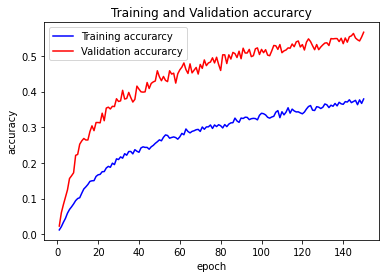

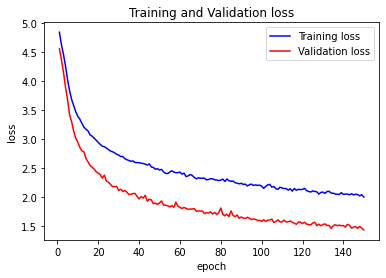

In [ ]:
acc = his_L_1['accuracy']
val_acc = his_L_1['val_accuracy']
loss = his_L_1['loss']
val_loss = his_L_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/model_MBLarge.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpzzy8quqr/assets


INFO:tensorflow:Assets written to: /tmp/tmpzzy8quqr/assets


13071620

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.39      0.50      0.44        24
         airplane       0.92      0.92      0.92        24
            angry       0.56      0.79      0.66        24
           animal       0.36      0.50      0.42        24
              bat       0.74      0.83      0.78        24
             bite       0.58      0.62      0.60        24
     bow the head       0.72      0.88      0.79        24
             bowl       0.53      0.42      0.47        24
            bread       1.00      0.08      0.15        24
          buffalo       0.69      0.83      0.75        24
             care       0.80      0.67      0.73        24
              cat       0.51      0.92      0.66        24
            chest       0.77      0.42      0.54        24
           cockle       0.48      0.67      0.56        24
            cough       0.74      0.83      0.78        24
              cow       0.64      0.29      0.40       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


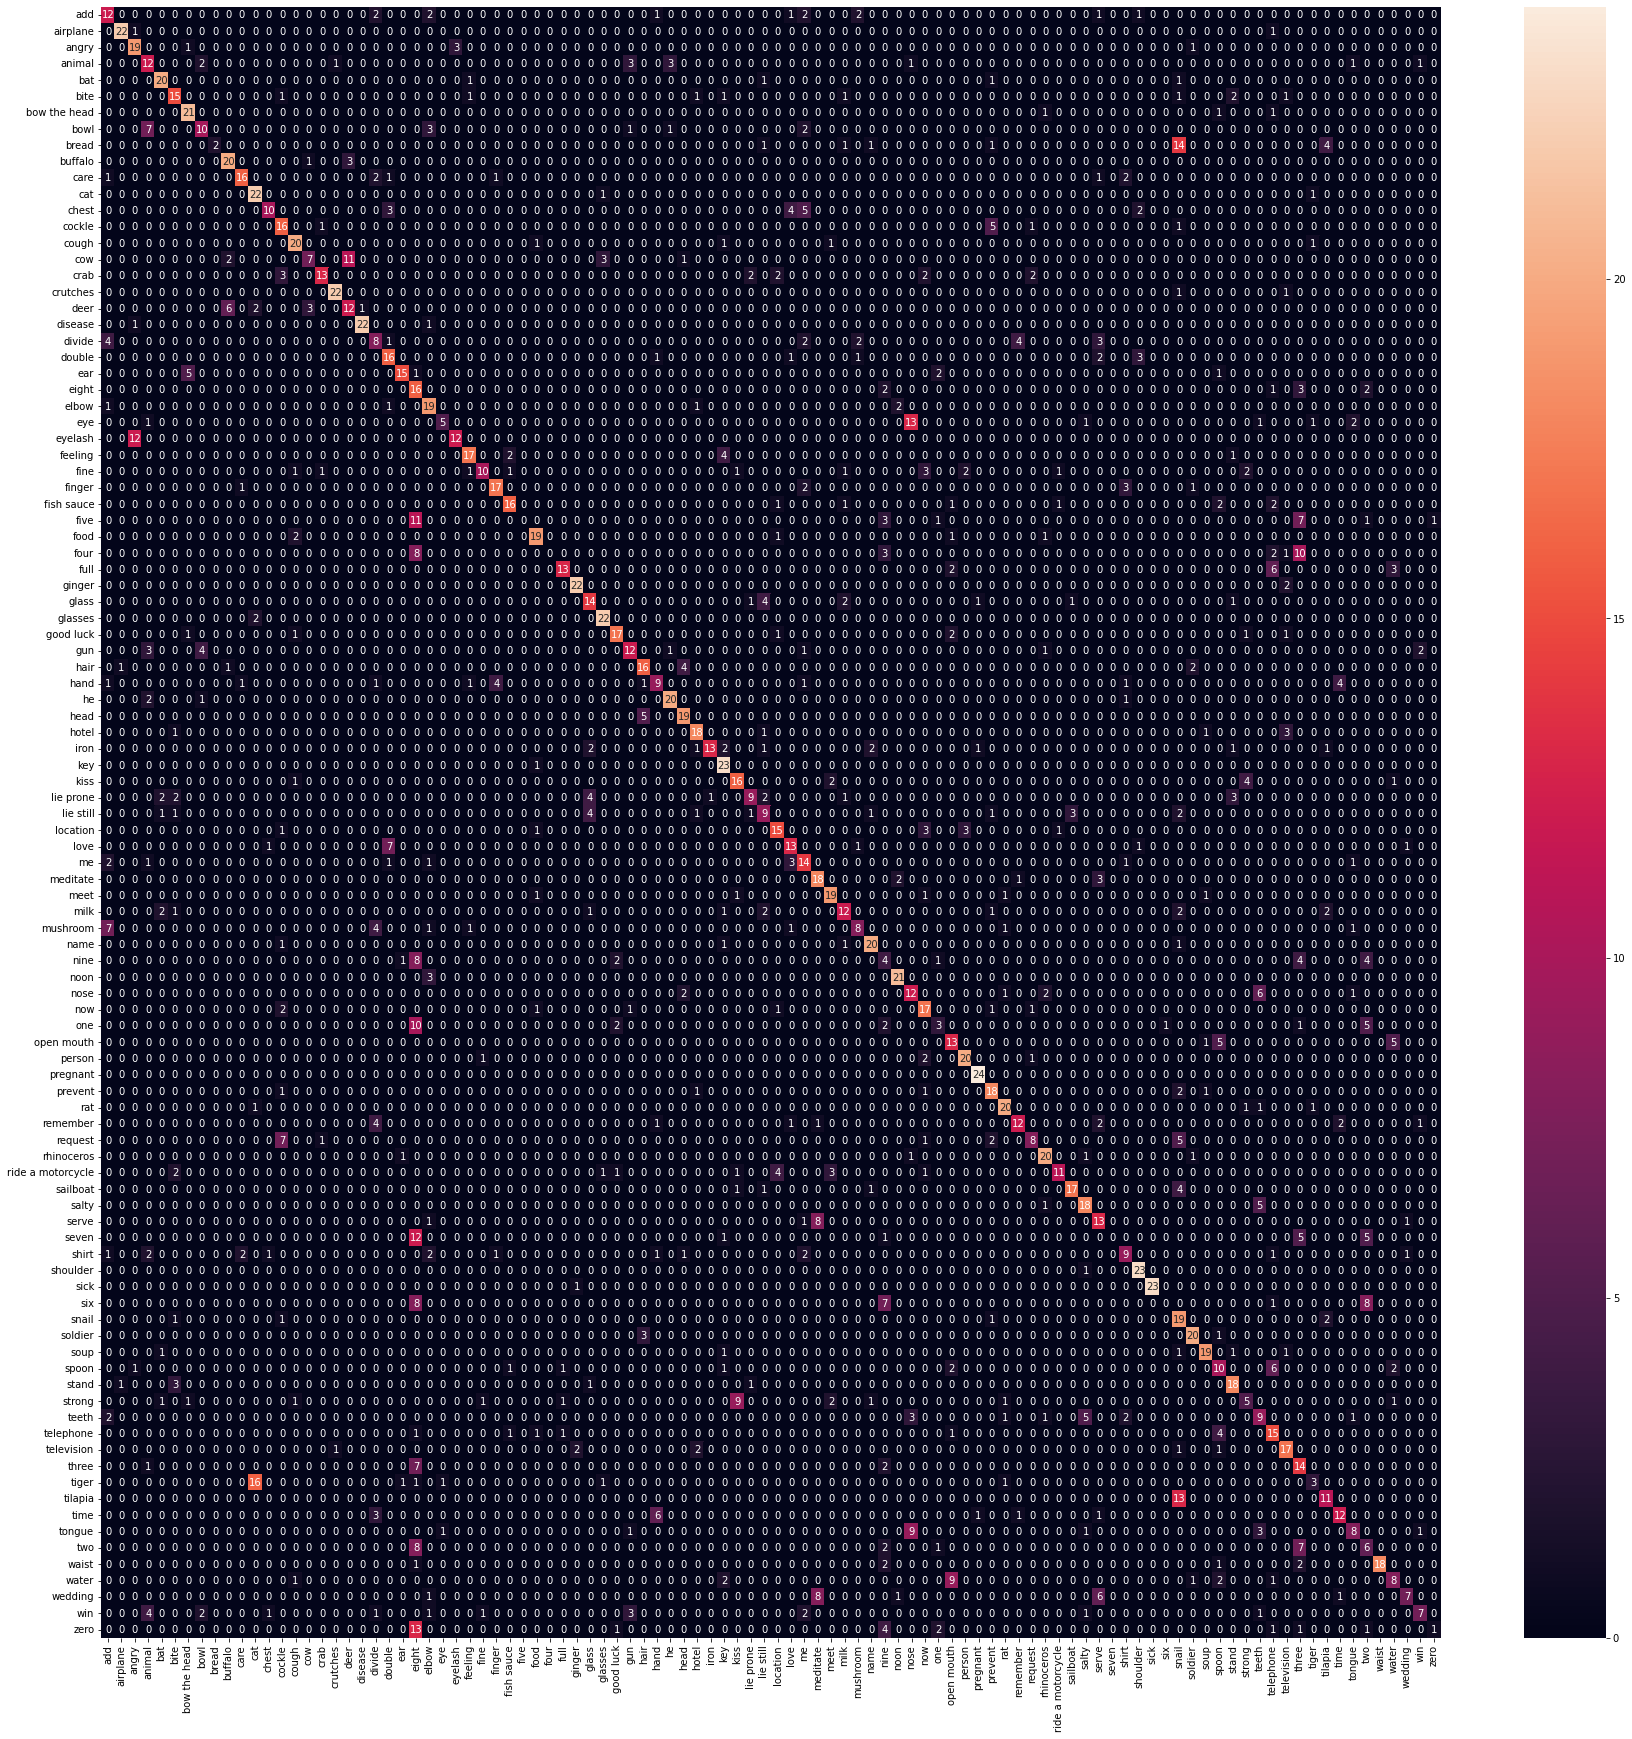

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

#MobileNetV3 Small

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

In [ ]:
model_MBSmall_1= create_model(conv_base_MobileNet)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                           

In [ ]:
SAVE_model_MBSmall_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/model_MBSmall_1.h5'
EPOCH = 150
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBSmall_1)
model_MBSmall_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history2_1= model_MBSmall_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/150
262/262 [==============================] - 47s 166ms/step - loss: 4.8249 - accuracy: 0.0117 - val_loss: 4.6020 - val_accuracy: 0.0127
Epoch 2/150
262/262 [==============================] - 42s 161ms/step - loss: 4.5896 - accuracy: 0.0229 - val_loss: 4.4183 - val_accuracy: 0.0524
Epoch 3/150
262/262 [==============================] - 42s 159ms/step - loss: 4.3573 - accuracy: 0.0357 - val_loss: 4.0531 - val_accuracy: 0.0709
Epoch 4/150
262/262 [==============================] - 42s 160ms/step - loss: 4.1391 - accuracy: 0.0448 - val_loss: 3.7981 - val_accuracy: 0.0988
Epoch 5/150
262/262 [==============================] - 42s 159ms/step - loss: 3.9657 - accuracy: 0.0551 - val_loss: 3.5872 - val_accuracy: 0.1132
Epoch 6/150
262/262 [==============================] - 42s 159ms/step - loss: 3.7996 - accuracy: 0.0611 - val_loss: 3.4391 - val_accuracy: 0.1250
Epoch 7/150
262/262 [==============================] - 42s 161ms/step - loss: 3.6781 - accuracy: 0.0755 - val_loss: 3.3199 -

###Result 

In [ ]:
history2_1.history

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/history2_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history2_1.history, file_pi)

In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

with open(pathCSV  , 'rb') as handle:
    history_Load_history2_1= load(handle)

In [ ]:
history_Load_history2_1

In [ ]:
from keras.models import load_model
model = load_model(SAVE_model_MBSmall_1)

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 11s 136ms/step - loss: 1.5415 - accuracy: 0.5300
test_acc: 0.5299999713897705
test_loss: 1.5415295362472534


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt
his_1 = '/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/history2_1.csv'
with open(his_1 , 'rb') as handle:
    his_L_1 = load(handle)

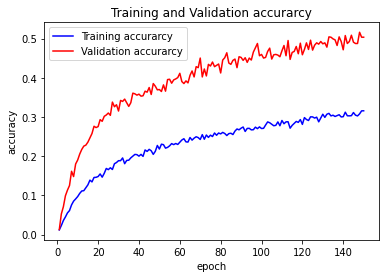

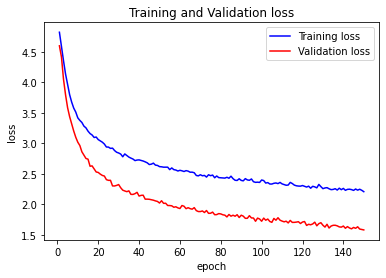

In [ ]:
acc = his_L_1['accuracy']
val_acc = his_L_1['val_accuracy']
loss = his_L_1['loss']
val_loss = his_L_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Pretrain//model_MBSmall.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpmz5gxqcx/assets


INFO:tensorflow:Assets written to: /tmp/tmpmz5gxqcx/assets


4516284

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.21      0.17      0.19        24
         airplane       0.66      0.79      0.72        24
            angry       0.46      0.46      0.46        24
           animal       0.36      0.42      0.38        24
              bat       1.00      0.04      0.08        24
             bite       0.80      0.83      0.82        24
     bow the head       0.68      0.62      0.65        24
             bowl       0.61      0.58      0.60        24
            bread       0.67      0.08      0.15        24
          buffalo       0.54      0.92      0.68        24
             care       0.52      0.46      0.49        24
              cat       0.50      1.00      0.67        24
            chest       0.62      0.42      0.50        24
           cockle       0.25      0.46      0.32        24
            cough       0.58      0.46      0.51        24
              cow       0.67      0.75      0.71       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


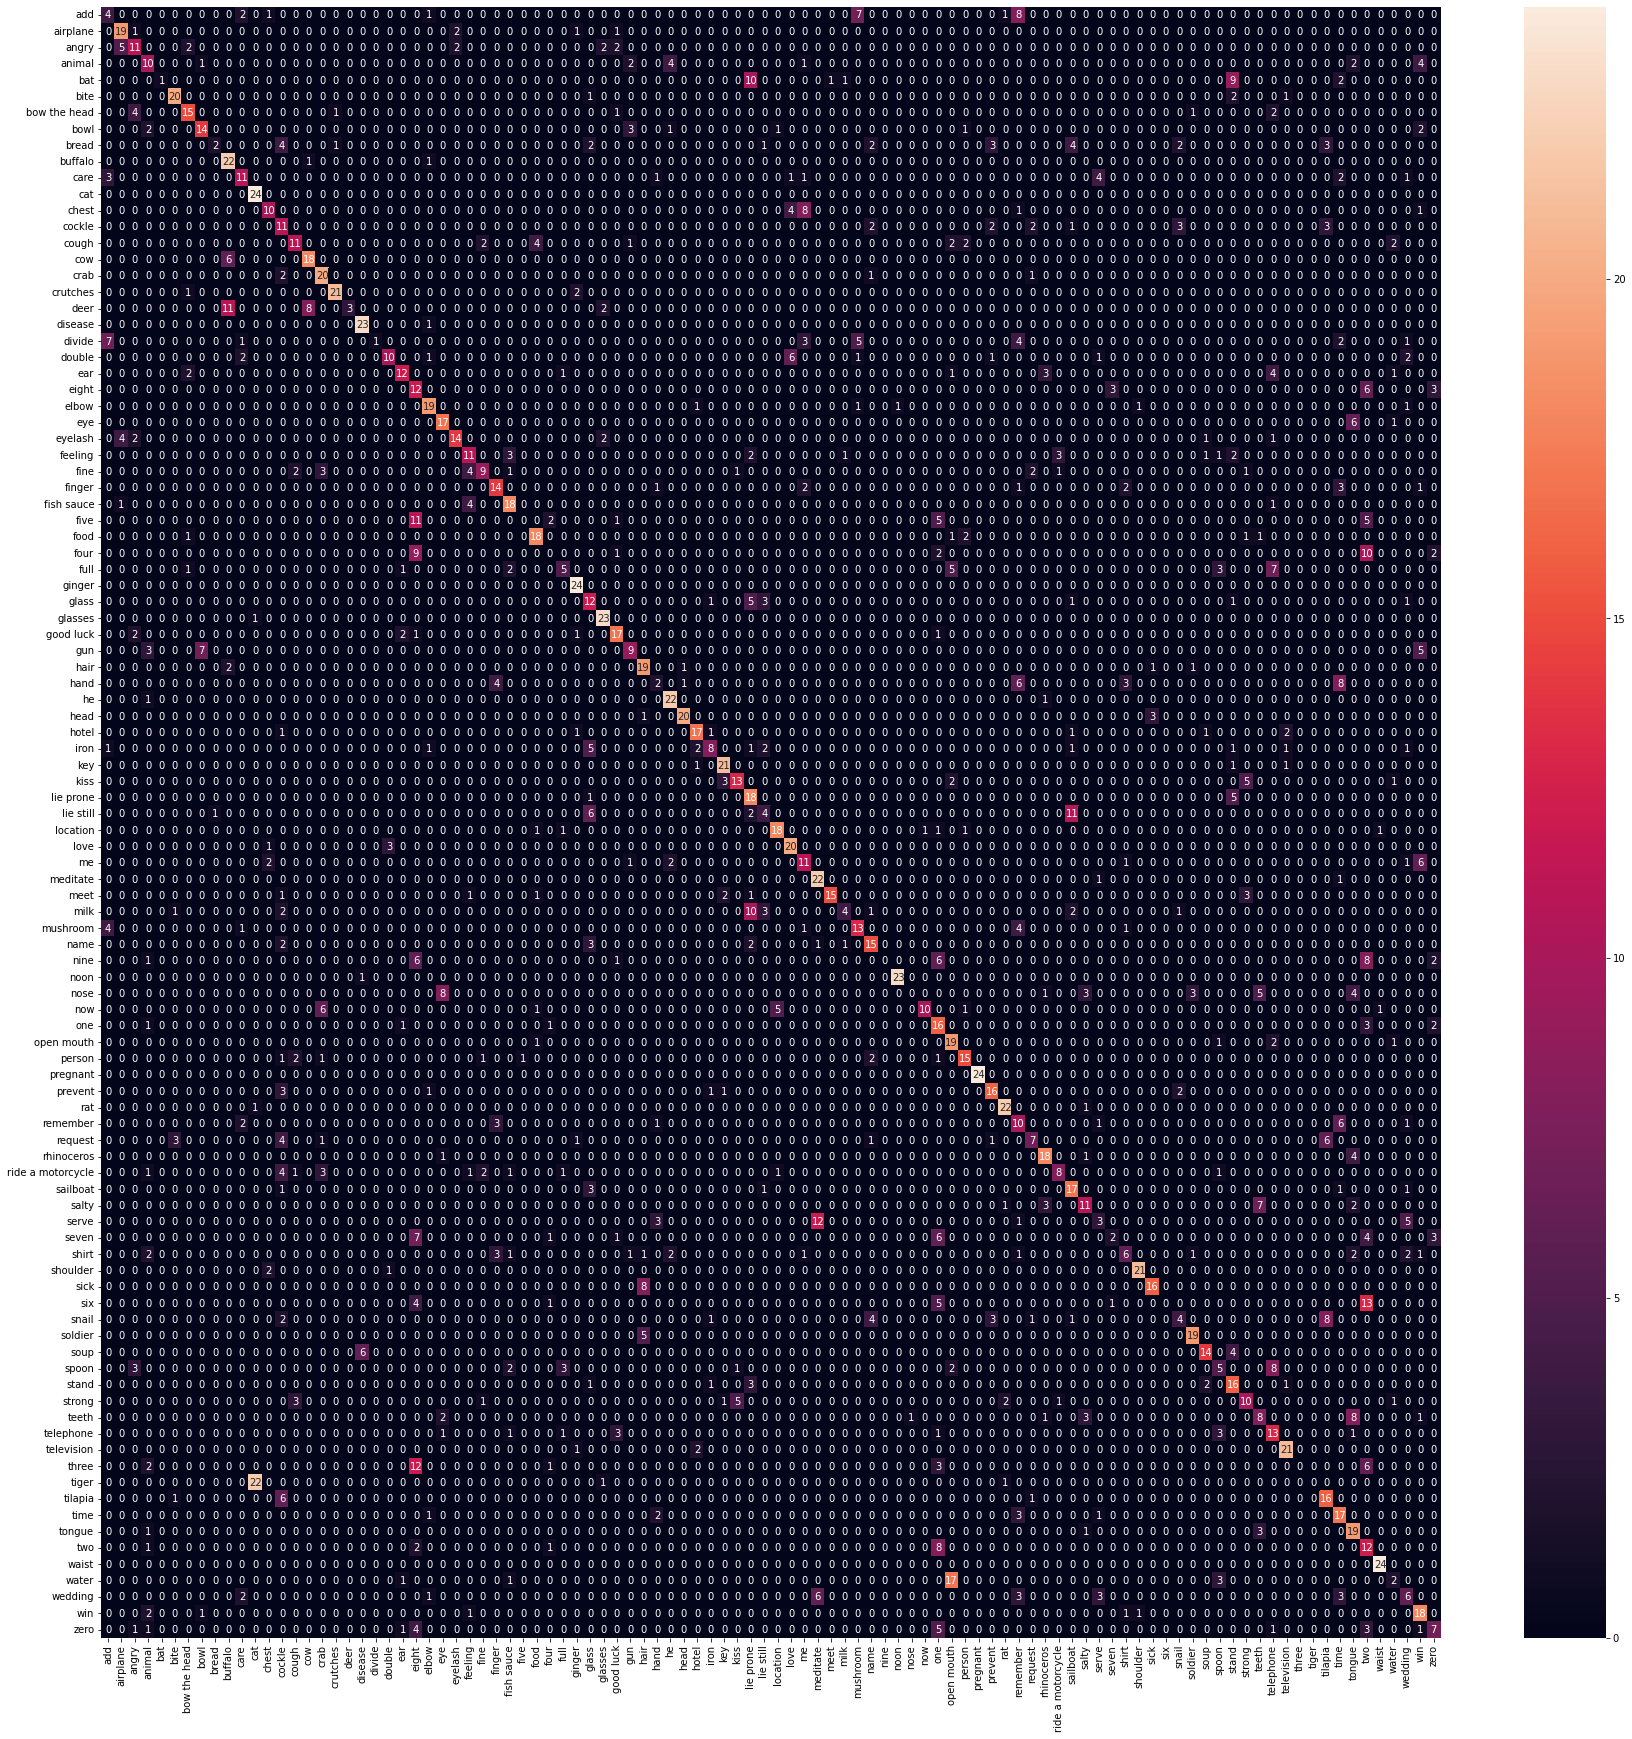

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

#MobileNetV2

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

In [ ]:
model_MBv2_1= create_model(conv_base_MobileNet)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
SAVE_model_MBv2_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/model_MBv2_1.h5'
EPOCH = 150
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_1)
model_MBv2_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history3_1= model_MBv2_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/150
262/262 [==============================] - 46s 161ms/step - loss: 4.6603 - accuracy: 0.0220 - val_loss: 4.0224 - val_accuracy: 0.1208
Epoch 2/150
262/262 [==============================] - 40s 152ms/step - loss: 4.1206 - accuracy: 0.0566 - val_loss: 3.4127 - val_accuracy: 0.1867
Epoch 3/150
262/262 [==============================] - 42s 160ms/step - loss: 3.6833 - accuracy: 0.0992 - val_loss: 3.0257 - val_accuracy: 0.2551
Epoch 4/150
262/262 [==============================] - 42s 159ms/step - loss: 3.3790 - accuracy: 0.1209 - val_loss: 2.6900 - val_accuracy: 0.3345
Epoch 5/150
262/262 [==============================] - 41s 158ms/step - loss: 3.1329 - accuracy: 0.1561 - val_loss: 2.4427 - val_accuracy: 0.3970
Epoch 6/150
262/262 [==============================] - 42s 160ms/step - loss: 2.9681 - accuracy: 0.1822 - val_loss: 2.2383 - val_accuracy: 0.4510
Epoch 7/150
262/262 [==============================] - 42s 159ms/step - loss: 2.7860 - accuracy: 0.2079 - val_loss: 2.0449 -

###Result 

In [ ]:
history3_1.history

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/history3_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history3_1.history, file_pi)

In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

with open(pathCSV  , 'rb') as handle:
    history_Load_history3_1= load(handle)

In [ ]:
history_Load_history3_1

In [ ]:
from keras.models import load_model
model = load_model(SAVE_model_MBv2_1 )

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 18s 241ms/step - loss: 0.6578 - accuracy: 0.7950
test_acc: 0.7950000166893005
test_loss: 0.6578452587127686


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt
his_1 = '/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/history3_1.csv'
with open(his_1 , 'rb') as handle:
    his_L_1 = load(handle)

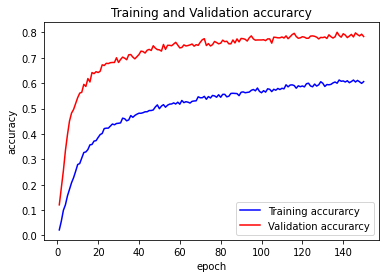

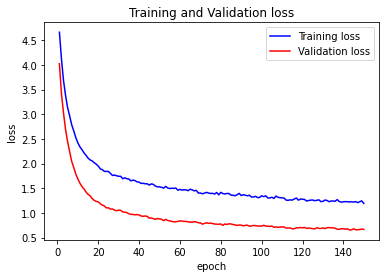

In [ ]:
acc = his_L_1['accuracy']
val_acc = his_L_1['val_accuracy']
loss = his_L_1['loss']
val_loss = his_L_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/model_MBv2.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmp5qia3dj1/assets


10363024

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.57      0.88      0.69        24
         airplane       0.96      0.92      0.94        24
            angry       0.95      0.88      0.91        24
           animal       0.67      0.58      0.62        24
              bat       0.83      0.83      0.83        24
             bite       1.00      0.88      0.93        24
     bow the head       0.89      1.00      0.94        24
             bowl       0.90      0.79      0.84        24
            bread       0.74      0.83      0.78        24
          buffalo       0.91      0.88      0.89        24
             care       1.00      0.92      0.96        24
              cat       0.88      0.92      0.90        24
            chest       0.62      0.62      0.62        24
           cockle       1.00      0.88      0.93        24
            cough       0.92      1.00      0.96        24
              cow       0.88      0.96      0.92       

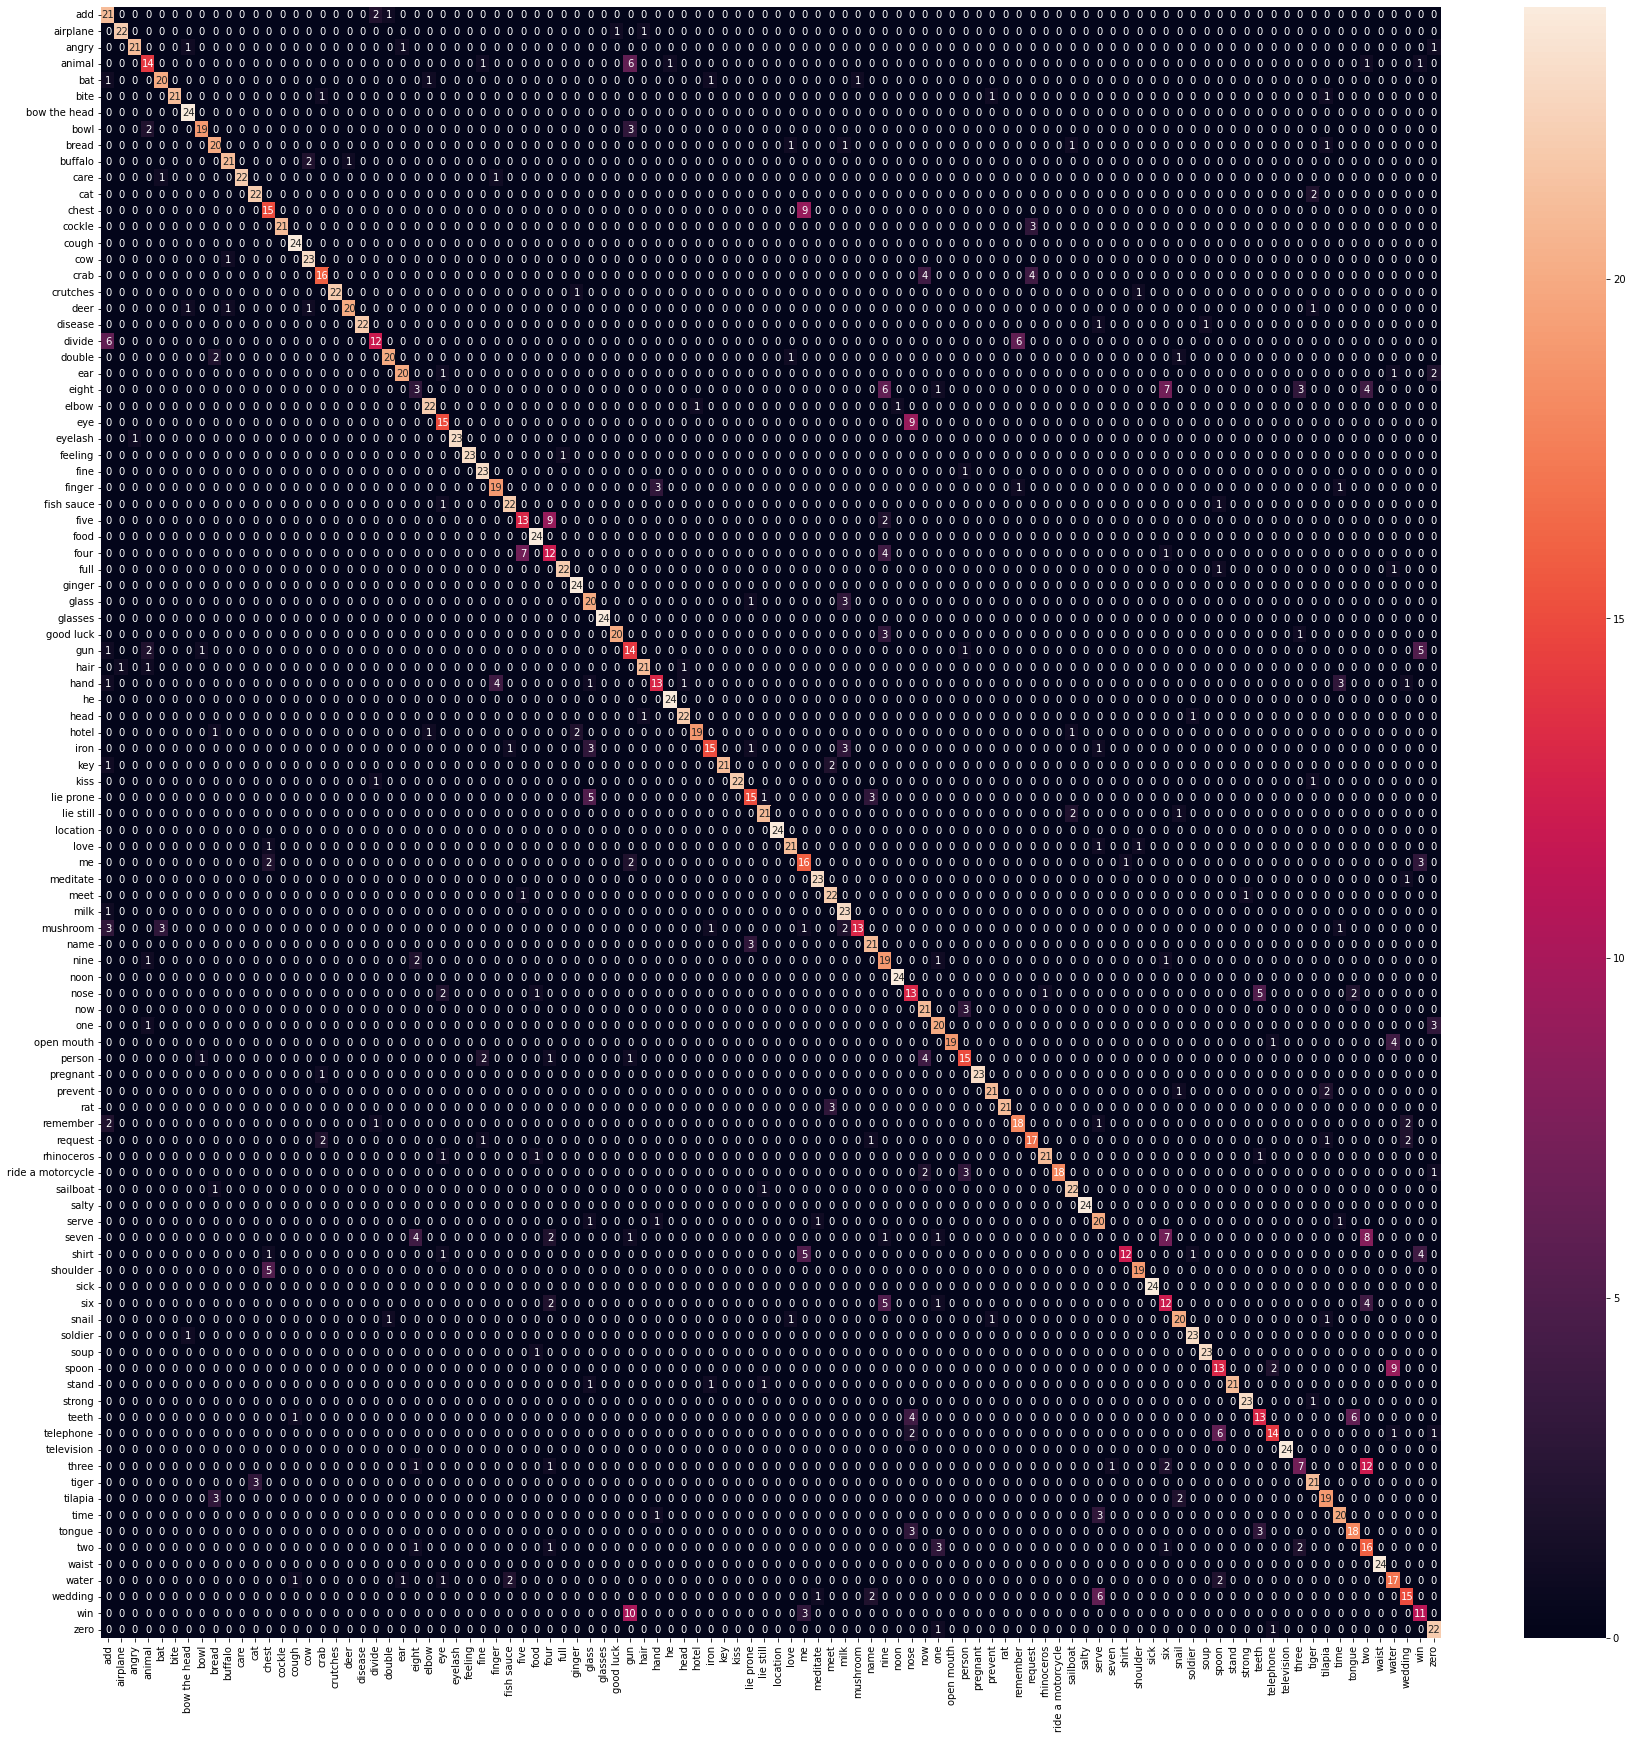

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

#Recap graph Pre-train model

In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

Path_MBLarge = '/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/history1_1.csv'
with open(Path_MBLarge, 'rb') as handle:
    his_MBLarge = load(handle)

Path_MBSmall = '/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/history2_1.csv'
with open(Path_MBSmall, 'rb') as handle:
    his_MBSmall = load(handle)

Path_MBv2 = '/content/drive/MyDrive/All Dataset/Github/Find_Pretrain/history3_1.csv'
with open(Path_MBv2, 'rb') as handle:
    his_MBv2 = load(handle)



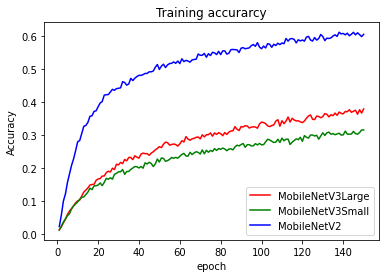

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Accuracy
acc1 = his_MBLarge['accuracy']
acc2 = his_MBSmall['accuracy']
acc3 = his_MBv2['accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='MobileNetV3Large')
plt.plot(epochs2, acc2, 'g', label='MobileNetV3Small')
plt.plot(epochs3, acc3, 'b', label='MobileNetV2')
plt.title('Training accurarcy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()


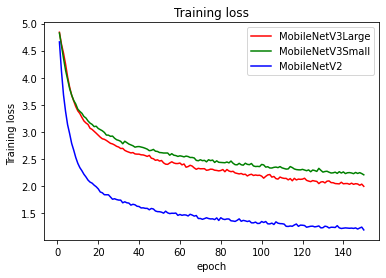

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Loss
acc1 = his_MBLarge['loss']
acc2 = his_MBSmall['loss']
acc3 = his_MBv2['loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
#Train and validation accuracy
plt.plot(epochs1, acc1, 'r', label='MobileNetV3Large')
plt.plot(epochs2, acc2, 'g', label='MobileNetV3Small')
plt.plot(epochs3, acc3, 'b', label='MobileNetV2')
plt.title('Training loss')
plt.ylabel('Training loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

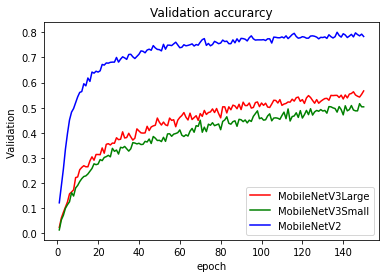

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Accuracy
acc1 = his_MBLarge['val_accuracy']
acc2 = his_MBSmall['val_accuracy']
acc3 = his_MBv2['val_accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='MobileNetV3Large')
plt.plot(epochs2, acc2, 'g', label='MobileNetV3Small')
plt.plot(epochs3, acc3, 'b', label='MobileNetV2')
plt.title('Validation accurarcy')
plt.ylabel('Validation ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

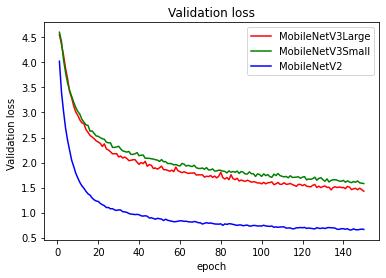

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Loss
acc1 = his_MBLarge['val_loss']
acc2 = his_MBSmall['val_loss']
acc3 = his_MBv2['val_loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='MobileNetV3Large')
plt.plot(epochs2, acc2, 'g', label='MobileNetV3Small')
plt.plot(epochs3, acc3, 'b', label='MobileNetV2')
plt.title('Validation loss')
plt.ylabel('Validation loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()